# K-Nearest Neighbor (KNN)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold

# Set random state for reproducibility
RANDOM_STATE = 42

In [2]:
import sys
from pathlib import Path

# Get current notebook directory
current_dir = Path.cwd()

# Move up until we find 'src'
for parent in current_dir.parents:
    if parent.name == "src":
        sys.path.append(str(parent))
        break
else:
    raise RuntimeError("Could not find 'src' directory")


from common import utils

In [3]:
# Load the CUP training data
ids, X, y = utils.load_cup_data(train=True)

# Split: 90% Development, 10% Internal Test
# We use the same random_state as other group members to ensure consistent splits
X_dev, X_test_internal, y_dev, y_test_internal = utils.split_data(X, y, test_size=0.1, random_state=RANDOM_STATE)

print(f"Total samples: {len(X)}")
print(f"Development Set shape: {X_dev.shape} (Used for Model Selection)")
print(f"Internal Test Set shape: {X_test_internal.shape} (Used ONLY for final check)")

Total samples: 500
Development Set shape: (450, 12) (Used for Model Selection)
Internal Test Set shape: (50, 12) (Used ONLY for final check)


In [4]:
# Define Hyperparameters to study
k_values = range(1, 30)  # Check K from 1 to 29
weights_strategies = ['uniform', 'distance'] # 'distance' weighs closer neighbors more heavily

# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = []

print("Starting Grid Search...")

for weight in weights_strategies:
    for k in k_values:
        fold_mees = []
        
        # Cross-Validation Loop
        for train_index, val_index in kf.split(X_dev):
            # 1. Split Data
            X_fold_train, X_fold_val = X_dev.iloc[train_index], X_dev.iloc[val_index]
            y_fold_train, y_fold_val = y_dev.iloc[train_index], y_dev.iloc[val_index]
            
            # 2. Normalize (Fit on TRAIN, Transform VALIDATION)
            scaler = utils.CupScaler()
            X_train_sc, y_train_sc = scaler.fit_transform(X_fold_train, y_fold_train)
            X_val_sc, y_val_sc = scaler.transform(X_fold_val, y_fold_val) # y_val_sc not strictly needed for prediction, but kept for consistency if needed
            
            # 3. Train KNN
            knn = KNeighborsRegressor(n_neighbors=k, weights=weight)
            knn.fit(X_train_sc, y_train_sc)
            
            # 4. Predict (Output is Scaled)
            y_pred_sc = knn.predict(X_val_sc)
            
            # 5. Inverse Transform Predictions (Back to Original Scale)
            y_pred_original = scaler.inverse_transform_y(y_pred_sc)
            
            # 6. Compute Error (MEE) in Original Space
            fold_mee = utils.mean_euclidean_error(y_fold_val, y_pred_original)
            fold_mees.append(fold_mee)
        
        # Average MEE across the 5 folds
        avg_mee = np.mean(fold_mees)
        results.append({
            'k': k, 
            'weight': weight, 
            'mee': avg_mee
        })

print("Grid Search Complete.")

Starting Grid Search...
Grid Search Complete.


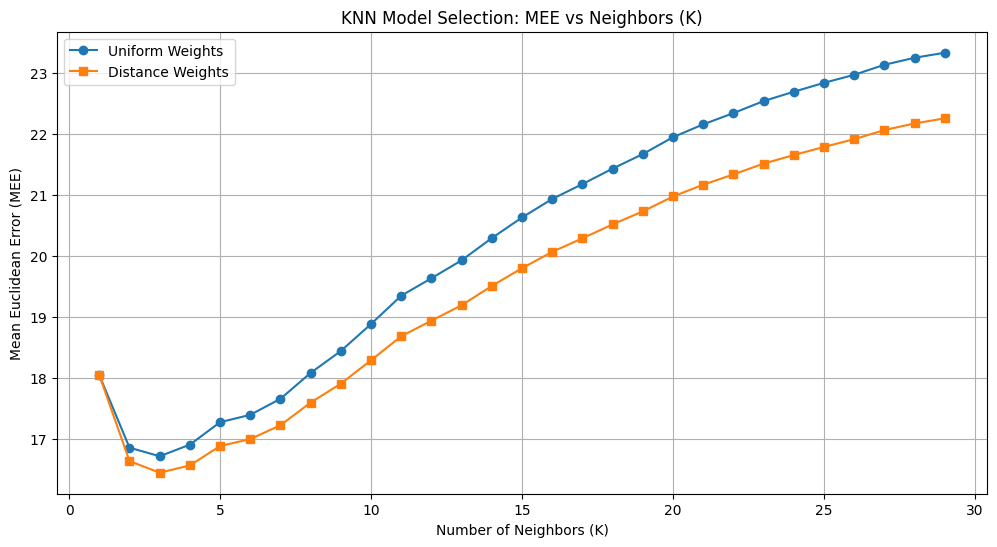

BEST CONFIGURATION: K=3, Weights=distance
Best Validation MEE: 16.4424


In [5]:
# Convert results to DataFrame for easy plotting
results_df = pd.DataFrame(results)

# Separate data for plotting
uniform_results = results_df[results_df['weight'] == 'uniform']
distance_results = results_df[results_df['weight'] == 'distance']

# Plot MEE vs K
plt.figure(figsize=(12, 6))
plt.plot(uniform_results['k'], uniform_results['mee'], marker='o', label='Uniform Weights')
plt.plot(distance_results['k'], distance_results['mee'], marker='s', label='Distance Weights')

plt.title('KNN Model Selection: MEE vs Neighbors (K)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Mean Euclidean Error (MEE)')
plt.legend()
plt.grid(True)
plt.show()

# Identify the Best Hyperparameters
best_row = results_df.loc[results_df['mee'].idxmin()]
best_k = int(best_row['k'])
best_weight = best_row['weight']
best_val_mee = best_row['mee']

print(f"BEST CONFIGURATION: K={best_k}, Weights={best_weight}")
print(f"Best Validation MEE: {best_val_mee:.4f}")

In [6]:
# 1. Retrain on Full Development Set
final_scaler = utils.CupScaler()
# Fit scaler on ALL dev data
X_dev_sc, y_dev_sc = final_scaler.fit_transform(X_dev, y_dev)

# Train final model
final_knn = KNeighborsRegressor(n_neighbors=best_k, weights=best_weight)
final_knn.fit(X_dev_sc, y_dev_sc)

# 2. Evaluate on Internal Test Set
# Transform Test inputs using the scaler fitted on Dev
X_test_sc, _ = final_scaler.transform(X_test_internal) 

# Predict
y_test_pred_sc = final_knn.predict(X_test_sc)

# Denormalize predictions
y_test_pred_original = final_scaler.inverse_transform_y(y_test_pred_sc)

# Compute Final Test Score
test_mee = utils.mean_euclidean_error(y_test_internal, y_test_pred_original)

print("-" * 30)
print(f"FINAL REPORT (KNN)")
print("-" * 30)
print(f"Selected Hyperparameters: K={best_k}, Weights={best_weight}")
print(f"Validation MEE (CV):      {best_val_mee:.4f}")
print(f"Internal Test MEE:        {test_mee:.4f}")
print("-" * 30)

------------------------------
FINAL REPORT (KNN)
------------------------------
Selected Hyperparameters: K=3, Weights=distance
Validation MEE (CV):      16.4424
Internal Test MEE:        15.1285
------------------------------
